In [1]:
import os
import random

import numpy as np
import pandas as pd
from PIL import Image
from time import time
from tqdm.auto import tqdm

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import CustomUnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

In [3]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '../data'
annotation_csv = '../data/annotation.csv'

In [4]:
# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

In [5]:
transform = torchvision.transforms.ToTensor()

unlabeled_trainset = CustomUnlabeledDataset(
    image_folder=image_folder,
    scene_index=unlabeled_scene_index,
)
trainloader = torch.utils.data.DataLoader(
    unlabeled_trainset,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

In [6]:
# [batch_size, 9, 3, H, W]
images, labels, original = iter(trainloader).next()
print(images.shape)

torch.Size([32, 9, 3, 75, 75])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


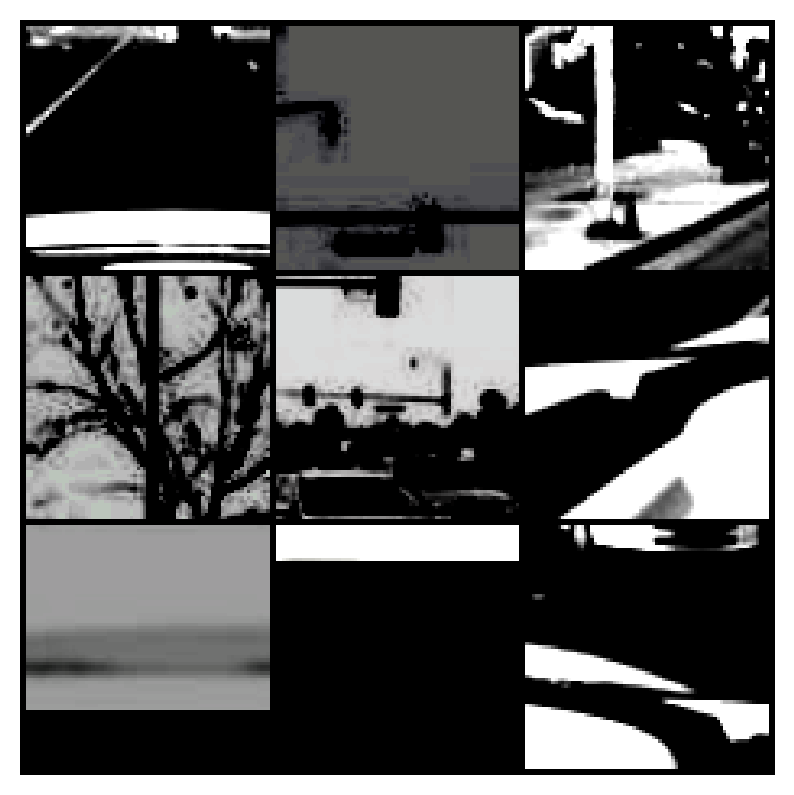

In [7]:
sample = 1
plt.imshow(torchvision.utils.make_grid(images[sample], nrow=3).numpy().transpose(1, 2, 0))
plt.axis('off');

In [8]:
# all_perm = np.load("permutations_1000.npy")
# # from range [1,9] to [0,8]
# if all_perm.mdin() == 1:
#     all_perm = all_perm - 1
#     
# temp = [original[np.arange(9)[t]] for t in range(9)]
# temp = torch.stack(temp, 0)
# 
# plt.imshow(torchvision.utils.make_grid(temp[:, sample, :, :, :], nrow=3).numpy().transpose(1, 2, 0))
# plt.axis('off');

In [9]:
from JigsawNetwork import Network
from Utils.TrainingUtils import compute_accuracy, adjust_learning_rate

# Network initialize
net = Network()
net.cuda()

Network(
  (conv): Sequential(
    (conv1_s1): Conv2d(3, 96, kernel_size=(11, 11), stride=(2, 2))
    (relu1_s1): ReLU(inplace=True)
    (pool1_s1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (lrn1_s1): LRN(
      (average): AvgPool3d(kernel_size=(5, 1, 1), stride=1, padding=(2, 0, 0))
    )
    (conv2_s1): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
    (relu2_s1): ReLU(inplace=True)
    (pool2_s1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (lrn2_s1): LRN(
      (average): AvgPool3d(kernel_size=(5, 1, 1), stride=1, padding=(2, 0, 0))
    )
    (conv3_s1): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3_s1): ReLU(inplace=True)
    (conv4_s1): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
    (relu4_s1): ReLU(inplace=True)
    (conv5_s1): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
    (

In [10]:
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(net.parameters(), lr=0.05, weight_decay=5e-4)

In [11]:
############## TRAINING ###############
batch_time, net_time = [], []
steps = 0
epochs = 3
for epoch in tqdm(range(epochs)):
    end = time()
    for i, (images, labels, original) in tqdm(enumerate(trainloader), leave=False):
        # lr = adjust_learning_rate(optimizer, epoch, init_lr=0.001, step=5, decay=0.1)
        batch_time.append(time() - end)
        if len(batch_time) > 100:
            del batch_time[0]

        images = images.cuda()
        labels = labels.cuda()

        # Forward + Backward + Optimize
        optimizer.zero_grad()
        t = time()
        outputs = net(images)
        net_time.append(time() - t)
        if len(net_time) > 100:
            del net_time[0]

        prec1, prec5 = compute_accuracy(
            outputs.cpu().data, labels.cpu().data, topk=(1, 5)
        )
        acc = prec1.item()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss = float(loss.cpu().data.numpy())

        if steps % 20 == 0:
            print(
                (
                    "[%2d/%2d] %5d) [batch load % 2.3fsec, net %1.2fsec], Loss: % 1.3f, Accuracy % 2.2f%%"
                    % (
                        epoch + 1,
                        epochs,
                        steps,
                        np.mean(batch_time),
                        np.mean(net_time),
                        # lr,
                        loss,
                        acc,
                    )
                )
            )

        steps += 1
        end = time()

[ 1/ 3]     0) [batch load  0.394sec, net 0.29sec], Loss:  6.907, Accuracy  0.00%
[ 1/ 3]    20) [batch load  0.125sec, net 0.03sec], Loss:  6.950, Accuracy  0.00%
[ 1/ 3]    40) [batch load  0.127sec, net 0.02sec], Loss:  6.889, Accuracy  0.00%
[ 1/ 3]    60) [batch load  0.129sec, net 0.02sec], Loss:  7.114, Accuracy  0.00%
[ 1/ 3]    80) [batch load  0.129sec, net 0.02sec], Loss:  6.989, Accuracy  0.00%
[ 1/ 3]   100) [batch load  0.124sec, net 0.01sec], Loss:  13950.690, Accuracy  0.00%
[ 1/ 3]   120) [batch load  0.128sec, net 0.01sec], Loss:  6.957, Accuracy  0.00%
[ 1/ 3]   140) [batch load  0.126sec, net 0.01sec], Loss:  7.123, Accuracy  0.00%
[ 1/ 3]   160) [batch load  0.123sec, net 0.01sec], Loss:  6.860, Accuracy  0.00%
[ 1/ 3]   180) [batch load  0.123sec, net 0.01sec], Loss:  6.927, Accuracy  0.00%
[ 1/ 3]   200) [batch load  0.126sec, net 0.01sec], Loss:  6.969, Accuracy  0.00%
[ 1/ 3]   220) [batch load  0.125sec, net 0.01sec], Loss:  7.117, Accuracy  0.00%
[ 1/ 3]   24

[ 1/ 3]  2000) [batch load  0.124sec, net 0.01sec], Loss:  7.018, Accuracy  0.00%
[ 1/ 3]  2020) [batch load  0.127sec, net 0.01sec], Loss:  53518.473, Accuracy  0.00%
[ 1/ 3]  2040) [batch load  0.127sec, net 0.01sec], Loss:  6.980, Accuracy  0.00%
[ 1/ 3]  2060) [batch load  0.127sec, net 0.01sec], Loss:  7.142, Accuracy  0.00%
[ 1/ 3]  2080) [batch load  0.129sec, net 0.01sec], Loss:  6.999, Accuracy  0.00%
[ 1/ 3]  2100) [batch load  0.128sec, net 0.01sec], Loss:  6.998, Accuracy  0.00%
[ 1/ 3]  2120) [batch load  0.129sec, net 0.01sec], Loss:  7.096, Accuracy  0.00%
[ 1/ 3]  2140) [batch load  0.128sec, net 0.01sec], Loss:  7.028, Accuracy  0.00%
[ 1/ 3]  2160) [batch load  0.127sec, net 0.01sec], Loss:  6.945, Accuracy  0.00%
[ 1/ 3]  2180) [batch load  0.127sec, net 0.01sec], Loss:  6.952, Accuracy  0.00%
[ 1/ 3]  2200) [batch load  0.126sec, net 0.01sec], Loss:  6.982, Accuracy  0.00%
[ 1/ 3]  2220) [batch load  0.126sec, net 0.01sec], Loss:  6.967, Accuracy  0.00%
[ 1/ 3]  224

[ 2/ 3]  2520) [batch load  0.123sec, net 0.01sec], Loss:  6.866, Accuracy  3.12%
[ 2/ 3]  2540) [batch load  0.123sec, net 0.01sec], Loss:  6.805, Accuracy  0.00%
[ 2/ 3]  2560) [batch load  0.122sec, net 0.01sec], Loss:  6.961, Accuracy  0.00%
[ 2/ 3]  2580) [batch load  0.120sec, net 0.01sec], Loss:  6.908, Accuracy  0.00%
[ 2/ 3]  2600) [batch load  0.117sec, net 0.01sec], Loss:  7.111, Accuracy  0.00%
[ 2/ 3]  2620) [batch load  0.117sec, net 0.01sec], Loss:  6.796, Accuracy  0.00%
[ 2/ 3]  2640) [batch load  0.115sec, net 0.01sec], Loss:  6.988, Accuracy  0.00%
[ 2/ 3]  2660) [batch load  0.116sec, net 0.01sec], Loss:  7.069, Accuracy  0.00%
[ 2/ 3]  2680) [batch load  0.118sec, net 0.01sec], Loss:  6.949, Accuracy  0.00%
[ 2/ 3]  2700) [batch load  0.119sec, net 0.01sec], Loss:  7.010, Accuracy  0.00%
[ 2/ 3]  2720) [batch load  0.119sec, net 0.01sec], Loss:  7.029, Accuracy  0.00%
[ 2/ 3]  2740) [batch load  0.121sec, net 0.01sec], Loss:  6.872, Accuracy  0.00%
[ 2/ 3]  2760) [

[ 2/ 3]  4520) [batch load  0.125sec, net 0.01sec], Loss:  7.026, Accuracy  0.00%
[ 2/ 3]  4540) [batch load  0.125sec, net 0.01sec], Loss:  6.990, Accuracy  0.00%
[ 2/ 3]  4560) [batch load  0.126sec, net 0.01sec], Loss:  6.993, Accuracy  0.00%
[ 2/ 3]  4580) [batch load  0.124sec, net 0.01sec], Loss:  7.089, Accuracy  0.00%
[ 2/ 3]  4600) [batch load  0.124sec, net 0.01sec], Loss:  6.931, Accuracy  0.00%
[ 2/ 3]  4620) [batch load  0.125sec, net 0.01sec], Loss:  6.956, Accuracy  0.00%
[ 2/ 3]  4640) [batch load  0.125sec, net 0.01sec], Loss:  7.049, Accuracy  0.00%
[ 2/ 3]  4660) [batch load  0.124sec, net 0.01sec], Loss:  7.053, Accuracy  0.00%
[ 2/ 3]  4680) [batch load  0.126sec, net 0.01sec], Loss:  6.978, Accuracy  0.00%
[ 2/ 3]  4700) [batch load  0.126sec, net 0.01sec], Loss:  7.031, Accuracy  3.12%
[ 2/ 3]  4720) [batch load  0.128sec, net 0.01sec], Loss:  6.962, Accuracy  0.00%
[ 2/ 3]  4740) [batch load  0.128sec, net 0.01sec], Loss:  6.866, Accuracy  3.12%
[ 2/ 3]  4760) [

[ 3/ 3]  5020) [batch load  0.124sec, net 0.01sec], Loss:  6.900, Accuracy  0.00%
[ 3/ 3]  5040) [batch load  0.126sec, net 0.01sec], Loss:  6.998, Accuracy  0.00%
[ 3/ 3]  5060) [batch load  0.129sec, net 0.01sec], Loss:  7.036, Accuracy  0.00%
[ 3/ 3]  5080) [batch load  0.132sec, net 0.01sec], Loss:  6.949, Accuracy  0.00%
[ 3/ 3]  5100) [batch load  0.132sec, net 0.01sec], Loss:  7.008, Accuracy  0.00%
[ 3/ 3]  5120) [batch load  0.132sec, net 0.01sec], Loss:  7.047, Accuracy  0.00%
[ 3/ 3]  5140) [batch load  0.132sec, net 0.01sec], Loss:  6.845, Accuracy  0.00%
[ 3/ 3]  5160) [batch load  0.132sec, net 0.01sec], Loss:  7.154, Accuracy  0.00%
[ 3/ 3]  5180) [batch load  0.133sec, net 0.01sec], Loss:  6.990, Accuracy  0.00%
[ 3/ 3]  5200) [batch load  0.133sec, net 0.01sec], Loss:  7.065, Accuracy  0.00%
[ 3/ 3]  5220) [batch load  0.133sec, net 0.01sec], Loss:  6.980, Accuracy  0.00%
[ 3/ 3]  5240) [batch load  0.129sec, net 0.01sec], Loss:  6.962, Accuracy  0.00%
[ 3/ 3]  5260) [

[ 3/ 3]  7020) [batch load  0.116sec, net 0.01sec], Loss:  6.965, Accuracy  0.00%
[ 3/ 3]  7040) [batch load  0.118sec, net 0.01sec], Loss:  7.087, Accuracy  0.00%
[ 3/ 3]  7060) [batch load  0.119sec, net 0.01sec], Loss:  6.945, Accuracy  0.00%
[ 3/ 3]  7080) [batch load  0.122sec, net 0.01sec], Loss:  6.918, Accuracy  0.00%
[ 3/ 3]  7100) [batch load  0.125sec, net 0.01sec], Loss:  7.036, Accuracy  0.00%
[ 3/ 3]  7120) [batch load  0.125sec, net 0.01sec], Loss:  7.053, Accuracy  0.00%
[ 3/ 3]  7140) [batch load  0.126sec, net 0.01sec], Loss:  7.041, Accuracy  0.00%
[ 3/ 3]  7160) [batch load  0.126sec, net 0.01sec], Loss:  7.074, Accuracy  0.00%
[ 3/ 3]  7180) [batch load  0.126sec, net 0.01sec], Loss:  7.040, Accuracy  0.00%
[ 3/ 3]  7200) [batch load  0.125sec, net 0.01sec], Loss:  6.789, Accuracy  0.00%
[ 3/ 3]  7220) [batch load  0.122sec, net 0.01sec], Loss:  7.196, Accuracy  0.00%
[ 3/ 3]  7240) [batch load  0.122sec, net 0.01sec], Loss:  6.970, Accuracy  0.00%
[ 3/ 3]  7260) [